# Seminar

In [1]:
#!L
import math
import os
import shutil
import sys
import string
import time
from collections import defaultdict
from typing import List, Tuple, TypeVar, Optional, Callable, Iterable, Union
from typing_extensions import Literal

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable


# import wandb
from torch import optim
from tqdm.notebook import tqdm
from IPython.display import clear_output

from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

/home/ttsrnd/knyazev/envs/rnd_train_venv/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Dataset

In [2]:
# Download LibriSpeech 100hr training and test data

dataset_dir = '../data'
if not os.path.isdir(dataset_dir):
    os.makedirs(dataset_dir)

train_dataset = torchaudio.datasets.LIBRISPEECH(dataset_dir, url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH(dataset_dir, url="test-clean", download=False)

In [3]:
import json
with open('index_to_speaker.json') as f:
    index_to_speaker = json.load(f)
with open('speaker_to_index.json') as f:
    speaker_to_index = json.load(f)

In [4]:
from torchaudio import transforms as T
import torchvision

sample_rate=16000
n_mels=80

train_audio_transforms = nn.Sequential(
    T.MelSpectrogram(n_mels=n_mels, sample_rate=sample_rate),
    torchvision.transforms.RandomApply(
            torch.nn.ModuleList([
                torchaudio.transforms.FrequencyMasking(freq_mask_param=20), 
                torchaudio.transforms.TimeMasking(time_mask_param=40)])
    )
)

test_audio_transforms = nn.Sequential(
    T.MelSpectrogram(n_mels=n_mels, sample_rate=sample_rate)
)

In [5]:
class Collate:
    def __init__(self, data_type = 'test') -> None:
        super(Collate, self).__init__() 

        self.data_type = data_type

    def __call__(self, data: torchaudio.datasets.librispeech.LIBRISPEECH) -> Tuple[List[torch.Tensor], ...]:
        """
        :param data: is a list of tuples of [features, label], where features has dimensions [n_features, length]
        "returns features, lengths, labels: 
              features is a Tensor [batchsize, features, max_length]
              lengths is a Tensor of lengths [batchsize]
              labels is a Tesnor of targets [batchsize]
        """

        spectrograms = []
        labels = []
        input_lengths = []
        for (waveform, _, _, speaker_id, _, _) in data:
            if self.data_type == 'train':
                spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            elif self.data_type == 'test':
                spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
            else:
                raise Exception('data_type should be train or valid')
            
            spectrograms.append(torch.log(spec + 1e-3))
            label = torch.LongTensor([speaker_to_index[str(speaker_id)]])
            labels.append(label)
            input_lengths.append(spec.shape[0])

        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        labels = torch.cat(labels).view(-1, 1)
        return spectrograms, labels, input_lengths

## Loss

Lets rewrite standard combination of softmax and cross-entropy loss in a following way:

$$\begin{equation}
    L = -\frac{1}{M}\sum_{i=1}^{M}log\frac{e^{\mathbf{W_{y_{i}}^{T}}f(\mathbf{x}_{i}) + \mathbf{b}_{y_{i}}}}{\sum_{j=1}^{C}e^{\mathbf{W_{j}^{T}}f(\mathbf{x}_{j}) + \mathbf{b}_{j}}}
\end{equation}
$$
---

,where $M$ is a btach size, $x_i$ - i_th input in the batch and $f(\mathbf{x}_i)$ is a last output of some neural network. $\mathbf{W}$ and $\mathbf{b}$ are the weight and bias stands for classification layer.

Standard cross-entropy loss can be written as:

$$
\begin{equation}
L = \frac{1}{M}\sum_{i}L_{i} = \frac{1}{M}\sum_{i}-\log(\frac{e^{f_{y_{i}}}}{ \sum_{j}{e^{f_{j}}} }),
\end{equation}
$$
---

,where $f_{y_{i}} = \mathbf{W_{y_{i}}^{T}}f(\mathbf{x}_{i})$. In further equations $\mathbf{x}_{i}$ stands for $f(\mathbf{x}_{i})$. Bias term is supressed due to simplisity, as it doesn't somehow affect prediction quality.
So now we cat rewrite $L_i$ term of cross-entropy loss, using scalar product as:


$$
\begin{equation}
L_i=-\log\bigg(\frac{e^{\|\mathbf{W}_{y_i}\|\|\mathbf{x}_i\|\cos(\theta_{y_i})}}{\sum_je^{\|\mathbf{W}_j\|\|\mathbf{x}_i\|\cos(\theta_j)}}\bigg)
\end{equation}
$$
---

And now we can make $\cos(\theta_{y_i})$ penalty more strict, using separate angle for $y_i$:

$$
\begin{equation}\label{l_softmax_i}
L_i=
-\log\bigg(\frac{e^{\|\mathbf{W}_{y_i}\|\|\mathbf{x}_i\|\psi(\theta_{y_i})}}{
e^{\|\mathbf{W}_{y_i}\|\|\mathbf{x}_i\|\psi(\theta_{y_i})}+\sum_{j\neq y_i}e^{\|\mathbf{W}_j\|\|\mathbf{x}_i\|\cos(\theta_j)}
}\bigg)
\end{equation}
$$
---

$$
\begin{equation}
\psi(\theta)=
\left\{
{\begin{array}{*{20}{l}}
{\cos(m\theta),\ \ \ \ 0\leq\theta\leq\dfrac{\pi}{m}}\\
{\mathcal{D}(\theta),\ \ \ \ \dfrac{\pi}{m}<\theta\leq\pi}
\end{array}} \right.
\end{equation}
$$
---

$$
\begin{equation}
    \psi(\theta)=(-1)^k\cos(m\theta)-2k,\ \ \ \theta\in[\frac{k\pi}{m},\frac{(k+1)\pi}{m}], \ \ \
    k\in [0, m-1], \ \ \
    k\in \mathbb{Z}
\end{equation}
$$
---

This loss is called **Angular Softmax**. If we define $\psi(\theta)$ as $cos(\theta) - m$, we will get **Additive Margin Softmax**

$$
\begin{equation}
    \begin{aligned}
    L= \frac{1}{M}\sum_i-\log\bigg(\frac{e^{s\cdot(\cos\theta_{y_i} - m)}}{
    e^{s\cdot(\cos\theta_{y_i} - m)}+\sum_{j\neq y_i}e^{s\cdot\cos\theta_{y_i}}
    }\bigg) \\
    = \frac{1}{M}\sum_i-\log\bigg(\frac{e^{s\cdot(\mathbf{W}_{y_i}^Tf(\mathbf{x}_i) - m)}}{
    e^{s\cdot(\mathbf{W}_{y_i}^Tf(\mathbf{x}_i) - m)}+\sum_{j\neq y_i}e^{s\mathbf{W}_{y_i}^Tf(\mathbf{x}_i)}
    }\bigg)
    \end{aligned}
\end{equation}
$$
---

In [6]:
class ASoftmaxLoss(nn.Module):
    """
    Angular softmax (A-Softmax) loss

    A-Softmax loss that enables convolutional neural networks to learn angularly discriminative features.
    Geometrically, A-Softmax loss can be viewed as imposing discriminative constraints on a hypersphere manifold,
    which intrinsically matches the prior that input also lie on a manifold.

    References
    ----------
    A-Softmax
    - SphereFace: Deep Hypersphere Embedding for Face Recognition
      https://arxiv.org/abs/1704.08063
    - Zero-Shot Multi-Speaker Text-To-Speech with State-of-the-art Neural Speaker Embeddings
      https://arxiv.org/abs/1910.10838
    """
    # source: https://github.com/clcarwin/sphereface_pytorch
    # AngleLoss class
    def __init__(self,
                 gamma=0,
                 lamb: float = 1500,
                 lambda_min: float = 5.0,
                 lambda_max: float = 1500.0):
        super(ASoftmaxLoss, self).__init__()
        self.gamma = gamma
        self.it = 0
        self.LambdaMin = lambda_min
        self.LambdaMax = lambda_max
        self.lamb = lamb

    def forward(self, target, cos_theta, phi_theta, weights=torch.tensor(1)):
        self.it += 1

        index = (cos_theta.data * 0.0).to(torch.int64)  # size=(B, Classnum)
        target = target.to(torch.int64)
        index.scatter_(1, target.data.view(-1, 1), 1)
        index = index.byte().detach().bool()

        self.lamb = max(self.LambdaMin, self.LambdaMax / (1 + 0.1 * self.it))
        output = cos_theta * 1.0  # size=(B, Classnum)
        output[index] -= cos_theta[index] * (1.0 + 0) / (1 + self.lamb)
        output[index] += phi_theta[index] * (1.0 + 0) / (1 + self.lamb)
        target = target.view(-1, 1)  # size=(B,1)

        logpt = F.log_softmax(output, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp().detach()

        loss = -1 * (1-pt)**self.gamma * logpt
        if weights.dim() > 0:
            loss *= weights
        loss = loss.mean()

        return loss

In [7]:
class AMSoftmaxLoss(nn.Module):
    """
    Additive Margin Softmax (AM-Softmax) loss

    References
    ----------
    Additive Margin Softmax
    - Additive Margin Softmax for Face Verification
      https://arxiv.org/pdf/1801.05599.pdf
    - Large-Margin Softmax Loss for Convolutional Neural Networks
      https://arxiv.org/pdf/1612.02295.pdf
    """
    def __init__(self, gamma=0):
        super(AMSoftmaxLoss, self).__init__()
        self.gamma = gamma

    def forward(self, target, cos_theta, phi_theta, weights=torch.tensor(1)):
        index = (cos_theta.data * 0.0).to(torch.int64)  # size=(B, Classnum)
        target = target.to(torch.int64)
        index.scatter_(1, target.data.view(-1, 1), 1)
        index = index.byte().detach().bool()

        output = cos_theta * 1.0  # size=(B, Classnum)
        output[index] -= cos_theta[index] * (1.0 + 0)
        output[index] += phi_theta[index] * (1.0 + 0)
        target = target.view(-1, 1)  # size=(B,1)
        
        logpt = F.log_softmax(output, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp().detach()

        loss = -1 * (1-pt)**self.gamma * logpt
        if weights.dim() > 0:
            loss *= weights
        loss = loss.mean()

        return loss

In [8]:
class AngleLinear(nn.Module):
    """
    Layer for loss.angle_loss.AngleLoss.

    Parameters
    ----------
    in_features : int
        Size of input features.
    out_features : int
        Number of classes for A-Softmax loss.
    m : int, default 4
        For adjusting size of angular margin.


    References
    ----------
    - SphereFace: Deep Hypersphere Embedding for Face Recognition
      https://arxiv.org/abs/1704.08063
    - Zero-Shot Multi-Speaker Text-To-Speech with State-of-the-art Neural Speaker Embeddings
      https://arxiv.org/abs/1910.10838
    """
    mlambda = [
        lambda x: x ** 0,
        lambda x: x ** 1,
        lambda x: 2 * x ** 2 - 1,
        lambda x: 4 * x ** 3 - 3 * x,
        lambda x: 8 * x ** 4 - 8 * x ** 2 + 1,
        lambda x: 16 * x ** 5 - 20 * x ** 3 + 5 * x
    ]

    def __init__(self, in_features,
                 out_features,
                 mode: Literal['angle', 'margin'] = 'margin',
                 m: Union[float, int] = 0.5,
                 s: Union[float, int] = 10.):
        super(AngleLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.mode = mode
        self.m = m
        self.s = s

    def angle_softmax(self, x, ww, xlen, wlen):
        cos_theta = x.mm(ww)  # size=(B,Classnum)
        cos_theta = cos_theta / xlen.view(-1, 1) / wlen.view(1, -1)
        cos_theta = cos_theta.clamp(-1, 1)

        cos_m_theta = self.mlambda[self.m](cos_theta)
        theta = Variable(cos_theta.data.acos())
        k = (self.m * theta / 3.14159265).floor()
        n_one = k * 0.0 - 1
        phi_theta = (n_one ** k) * cos_m_theta - 2 * k

        cos_theta = cos_theta * xlen.view(-1, 1)
        phi_theta = phi_theta * xlen.view(-1, 1)
        return cos_theta, phi_theta

    def margin_softmax(self, x, ww, xlen, wlen):
        cos_theta = x.mm(ww)  # size=(B,Classnum)
        cos_theta = cos_theta / xlen.view(-1, 1) / wlen.view(1, -1)
        cos_theta = cos_theta.clamp(-1, 1)

        phi_theta = self.s * (cos_theta - self.m)
        cos_theta = self.s * cos_theta
        return cos_theta, phi_theta

    def forward(self, input):
        x = input        # size=(B,F)    F is feature len
        w = self.weight  # size=(F,Classnum) F=in_features Classnum=out_features

        ww = w.renorm(2, 1, 1e-5).mul(1e5)
        xlen = x.pow(2).sum(1).pow(0.5)  # size=B
        wlen = ww.pow(2).sum(0).pow(0.5)  # size=Classnum

        if self.mode == "angle":
            return self.angle_softmax(x, ww, xlen, wlen)
        elif self.mode == "margin":
            return self.margin_softmax(x, ww, xlen, wlen)
        else:
            raise NotImplementedError

## Model

In [9]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNNs input"""

    def __init__(self, n_feats: int) -> None:
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)
    
class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """

    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel: int, 
                 stride: int, 
                 dropout: float, 
                 n_feats: int
                ) -> None:
        super(ResidualCNN, self).__init__()

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.res_connection = nn.Sequential(
            CNNLayerNorm(n_feats),
            nn.GELU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel // 2),
            CNNLayerNorm(n_feats // stride),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel, 1, padding=kernel // 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = self.shortcut(x)  # (batch, channel, feature, time)
        x = self.res_connection(x)
        x += residual
        return x  # (batch, channel, feature, time)


class FeatureExtractor(nn.Module):

    def __init__(self, 
                 kernel_sizes: List[int], 
                 strides: List[int], 
                 channels: List[int], 
                 out_dim: int,
                 dropout: float = 0.1
                ) -> None:
        super(FeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 7, stride=1, padding=7 // 2),
            CNNLayerNorm(80),
            nn.ReLU()
        )

        n_feats = [80]
        for s in strides[:-1]:
            n_feats.append(n_feats[-1] // s)
            
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(in_c, out_c, kernel, stride, dropout, feature_dim) for 
            in_c, out_c, kernel, stride, feature_dim in zip(
                [32] + channels[:-1], channels, kernel_sizes, strides, n_feats
            )
        ])
        
        feature_dim = channels[-1] * n_feats[-1]
        self.fully_connected = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.GELU(),
            nn.Linear(feature_dim, out_dim)
         )
      

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        return F.gelu(x)

    
class SpeakerEncoder(nn.Module):
    def __init__(self,
                 num_classes: int,
                 
                 # Feature extractor
                 kernel_sizes: List[int] = [5, 3, 3, 3, 3, 3], 
                 strides: List[int] = [2, 1, 2, 1, 2, 1], 
                 channels: List[int] = [64, 64, 128, 128, 64, 32], 
                 out_dim: int = 256,
                 dropout: float = 0.1,

                 # Args for AngleLinear
                 asoftmax: Literal['angle', 'margin'] = None,
                 m: float = 2,
                 s: int = 5,
                 ):
        super(SpeakerEncoder, self).__init__()
        
        self.asoftmax = asoftmax
        
        self.feature_extractor = FeatureExtractor(
            kernel_sizes,
            strides,
            channels,
            out_dim,
            dropout,
        )

        self.lstm = nn.LSTM(
            input_size=out_dim,
            hidden_size=out_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.1
        )
        
        out_lstm_dim = 2 * out_dim if self.lstm.bidirectional else out_dim
        # SAP
        self.attn = nn.Linear(out_lstm_dim, out_dim)
        self.v = nn.Linear(out_dim, 1)
        
        self.mlp = nn.Sequential(
            nn.Identity() if asoftmax else nn.ReLU(),
            AngleLinear(out_lstm_dim, num_classes, asoftmax, m, s) if asoftmax else nn.Linear(out_lstm_dim, num_classes),
            nn.Identity() if asoftmax else nn.LogSoftmax(dim=-1)
        )
        self.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        
    def SAP(self, x: torch.FloatTensor) -> torch.Tensor:
        """Self-attentive pooling layer"""
        energy = torch.tanh(self.attn(x))
        attention = self.v(energy).squeeze(-1)
        attn_scores = F.softmax(attention, dim=-1).unsqueeze(1)
        return attn_scores.bmm(x).squeeze(1)    

    def forward(self, x: torch.FloatTensor):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.feature_extractor(x)

        out, _ = self.lstm(x)
        emb = self.SAP(out)
        
        if self.asoftmax:
            cos_theta, phi_theta = self.mlp(emb)
            return emb, cos_theta, phi_theta, cos_theta.argmax(-1)
        log_soft_labels = self.mlp(emb)
        return emb, log_soft_labels, torch.tensor(0).to(emb.device), log_soft_labels.argmax(-1)

## Train

In [10]:
def train(model: nn.Module, 
          device: str, 
          train_loader: data.DataLoader, 
          val_loader: data.DataLoader, 
          criterion: nn.Module, 
          optimizer: torch.optim.Optimizer, 
          scheduler: torch.optim.lr_scheduler, 
          epoch: int) -> None:
    model.train()
    data_len = len(train_loader.dataset)
    
    losses = []
    all_labels_target = []
    all_labels_pred = []
    
    for batch_idx, _data in enumerate(tqdm(train_loader)):
        spectrograms, labels, input_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()

        emb, cos_theta, phi_theta, labels_pred = model(spectrograms)  # (batch, time, n_class)
        
        loss = criterion(labels, cos_theta, phi_theta)
        loss.backward()

        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        all_labels_pred.extend(labels_pred.cpu().detach().numpy())
        all_labels_target.extend(labels.cpu().detach().numpy())
        
        if batch_idx % 10 == 0 or batch_idx == data_len:
            # Logging
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                10. * batch_idx / len(train_loader), loss.item()))
        
        # Validation
        if batch_idx % 50 == 0 or batch_idx == data_len:
            val_labels_target = []
            val_labels_pred = []
            val_losses = []
            with torch.no_grad():
                for i, _data in enumerate(tqdm(val_loader)):
                    spectrograms, labels, input_lengths = _data
                    spectrograms, labels = spectrograms.to(device), labels.to(device)
            
                    emb, cos_theta, phi_theta, labels_pred = model(spectrograms)  # (batch, time, n_class)
                    loss = criterion(labels, cos_theta, phi_theta)
                    
                    val_losses.append(loss.item())
                    val_labels_pred.extend(labels_pred.cpu().detach().numpy())
                    val_labels_target.extend(labels.cpu().detach().numpy())
            
            f1_score_val = f1_score(val_labels_target, val_labels_pred, average='weighted')
            print (f"F1 val: {f1_score_val}\tLoss val: {np.mean(val_losses)}")

    f1_score_ = f1_score(all_labels_target, all_labels_pred, average='weighted')   
    return np.mean(losses), f1_score_


def test(model: nn.Module, 
         device: str, 
         test_loader: data.DataLoader, 
         criterion: nn.Module, 
         epoch: int,  
         save_path: str = None) -> None:
    print('Beginning eval...')
    model.eval()
    
    embs = []
    
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(tqdm(test_loader)):
            spectrograms, labels, input_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            emb, _, _, _ = model(spectrograms)  # (batch, time, n_class)
            embs.append(emb.cpu().detach().numpy())

    print('Epoch: {:d}\n'.format(epoch))
    return embs

In [11]:
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda:0'
else:
    print('Only CPU found! 💻')
    device = 'cpu'
    
class Config:
    sample_rate = 16000
    n_mels = 80
    
    batch_size = 30
    lr = 0.0003
    epochs = 1
    
    gamma = 2
    num_classes = len(os.listdir(os.path.join(dataset_dir, "LibriSpeech/train-clean-100/")))

config = Config()

train_collate_fn = Collate(data_type='train')
test_collate_fn = Collate(data_type='test')

GPU found! 🎉


In [12]:
origin_indices_permuted = np.random.permutation(len(train_dataset))

kwargs = {'num_workers': 4, 'pin_memory': True} if device == 'cuda' else {}
train_loader = data.DataLoader(
    data.Subset(train_dataset, origin_indices_permuted[:int(len(train_dataset) * 0.9)]), 
    batch_size=config.batch_size, 
    shuffle=True, 
    collate_fn=train_collate_fn, 
    **kwargs
)

kwargs = {'num_workers': 4, 'pin_memory': True} if device == 'cuda' else {}
val_loader = data.DataLoader(
    data.Subset(train_dataset, origin_indices_permuted[int(len(train_dataset) * 0.9):]),
    batch_size=config.batch_size, 
    shuffle=True, 
    collate_fn=test_collate_fn, 
    **kwargs
)

kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
test_loader = data.DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    shuffle=False, 
    collate_fn=test_collate_fn, 
    **kwargs
)

## AMSoftmax

In [41]:
model = SpeakerEncoder(num_classes=config.num_classes, asoftmax='margin').to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, )
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=0.001, 
    steps_per_epoch=len(train_loader), 
    epochs=config.epochs,
    pct_start=0.2
)
criterion = AMSoftmaxLoss(gamma=config.gamma)

In [ ]:
train_losses = []
f1_scores_train = []

embs = dict()
for epoch in tqdm(range(1, config.epochs + 1)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    train_loss, f1_score_train = train(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epoch)
    torch.save({'model_state_dict': model.state_dict()}, f"amsoftmax_{epoch}.tar")
    test_emb = test(model, device, test_loader, criterion, epoch)
    embs[epoch] = test_emb
    
    # Logging
    clear_output(True)
    train_losses.append(train_loss)
    f1_scores_train.append(f1_score_train)
    print (f"Current f0 score on train: {f1_score_train}")
    
    #Train
    ax[0].plot(train_losses, label="Train Loss")
    ax[0].set_title('Loss')
    
    # Test
    ax[1].plot(f1_scores_train, label="Train F1 score")
    ax[1].set_title('F1 score')
    
    plt.legend()
    plt.show()

## ASoftmax

In [ ]:
model = SpeakerEncoder(num_classes=config.num_classes, asoftmax='angle', m=2).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, )
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=config.epochs,
    pct_start=0.2
)
criterion = ASoftmaxLoss()

train_losses = []
f1_scores_train = []

embs = dict()
for epoch in tqdm(range(1, config.epochs + 1)):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    train_loss, f1_score_train = train(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epoch)
    torch.save({'model_state_dict': model.state_dict()}, f"{save_dir}asoftmax_{epoch}.tar")
    test_emb = test(model, device, test_loader, criterion, epoch)
    embs[epoch] = test_emb
    # Logging
    clear_output(True)
    train_losses.append(train_loss)
    f1_scores_train.append(f1_score_train)
    print(f"Current f0 score on train: {f1_score_train}")
    
    # Train
    ax[0].plot(train_losses, label="Train Loss")
    ax[0].set_title('Loss')
    
    # Test
    ax[1].plot(f1_scores_train, label="Train F1 score")
    ax[1].set_title('F1 score')
    plt.legend()
    plt.show()

## Embeddings

In [13]:
def compute_embs(model):
    embs = []
    speakers = []
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(tqdm(test_loader)):
            spectrograms, labels, input_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            emb, _, _, _ = model(spectrograms)  # (batch, time, n_class)
            embs.extend(emb.cpu().detach().numpy().tolist())
            speakers.extend(labels.cpu().detach().numpy().reshape(-1, ).tolist())
    return embs, speakers

def tsne_projection(embs, speakers):
    tsne = TSNE(n_components=2, verbose=1)
    projection = tsne.fit_transform(embs)

    df = pd.DataFrame()
    df['y'] = speakers
    df['label'] = df['y'].apply(lambda i: str(i))
    df['axis_1'] = projection[:, 0]
    df['axis_2'] = projection[:, 1]

    # 2D plot
    plt.figure(figsize=(16, 10))
    sns_plt = sns.scatterplot(
        x="axis_1", y="axis_2",
        hue="y",
        palette=sns.color_palette("deep", len(set(speakers))),
        data=df,
        legend="full",
        alpha=0.5
    )
    plt.show()

In [14]:
model = SpeakerEncoder(num_classes=config.num_classes, asoftmax='margin').to(device)
model.load_state_dict(torch.load('amsoftmax.tar')['model_state_dict'])

<All keys matched successfully>

  0%|          | 0/88 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2620 samples in 0.001s...
[t-SNE] Computed neighbors for 2620 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2620
[t-SNE] Computed conditional probabilities for sample 2000 / 2620
[t-SNE] Computed conditional probabilities for sample 2620 / 2620
[t-SNE] Mean sigma: 1.205011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.357456
[t-SNE] KL divergence after 1000 iterations: 0.600300


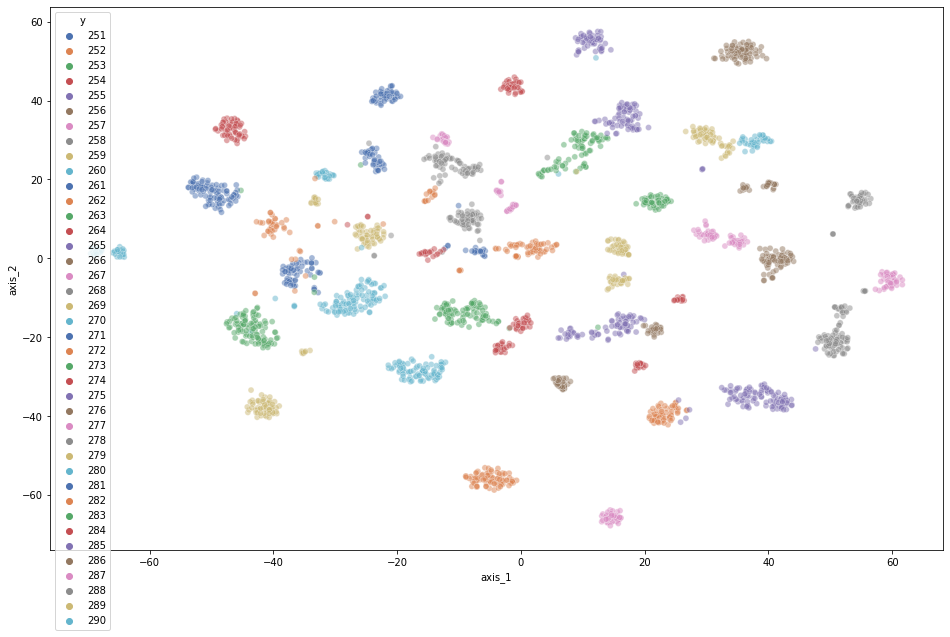

In [16]:
embs, speakers = compute_embs(model)
tsne_projection(embs, speakers)

In [17]:
model = SpeakerEncoder(num_classes=config.num_classes, asoftmax='angle').to(device)
model.load_state_dict(torch.load('asoftmax.tar')['model_state_dict'])

<All keys matched successfully>

  0%|          | 0/88 [00:00<?, ?it/s]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2620 samples in 0.001s...
[t-SNE] Computed neighbors for 2620 samples in 0.192s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2620
[t-SNE] Computed conditional probabilities for sample 2000 / 2620
[t-SNE] Computed conditional probabilities for sample 2620 / 2620
[t-SNE] Mean sigma: 3.353991
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.159508
[t-SNE] KL divergence after 1000 iterations: 0.751626


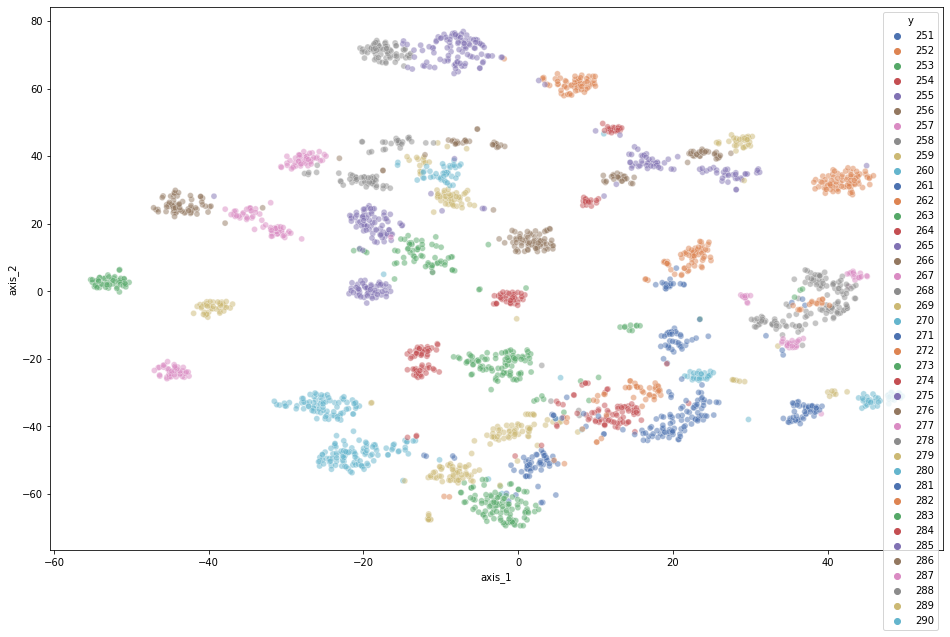

In [18]:
embs, speakers = compute_embs(model)
tsne_projection(embs, speakers)